Using device: cpu
Start Training ...
Epoch [1/10], Train Loss: 0.1191
Epoch [2/10], Train Loss: 0.0538
Epoch [3/10], Train Loss: 0.0503
Epoch [4/10], Train Loss: 0.0487
Epoch [5/10], Train Loss: 0.0477
Epoch [6/10], Train Loss: 0.0469
Epoch [7/10], Train Loss: 0.0464
Epoch [8/10], Train Loss: 0.0457
Epoch [9/10], Train Loss: 0.0455
Epoch [10/10], Train Loss: 0.0451
Test Loss: 0.0448


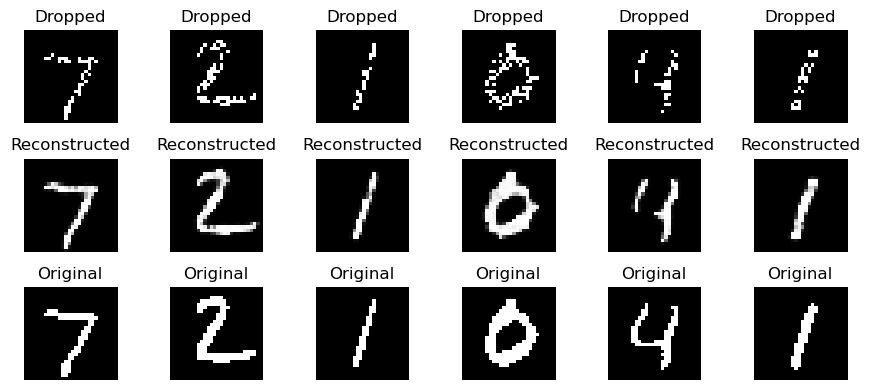

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import numpy as np

# --------------------------------------------------------------
#             1. Paramètres et configuration générale
# --------------------------------------------------------------
# Déterminer l'appareil à utiliser (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparamètres principaux
batch_size = 128
learning_rate = 1e-3
epochs = 10

# Proportion de bits à supprimer (drop) dans chaque segment
drop_prob = 0.3  

# --------------------------------------------------------------
#     2. Chargement du dataset MNIST et binarisation des images
# --------------------------------------------------------------
# Définition d'une fonction pour binariser les pixels : 0 ou 1
def binarize(tensor):
    # Tout pixel > 0.5 devient 1, sinon 0
    return (tensor > 0.5).float()

#  Transformation pour MNIST :
#     - Convertir en tenseur PyTorch (valeurs [0,1])
#     - Puis binariser chaque pixel
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: binarize(x)),
])

# Chargement du dataset MNIST (train et test)
train_dataset = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transform
)
test_dataset = datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

# Création des DataLoader pour itérer par batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# --------------------------------------------------------------
# 3. Fonction de suppression aléatoire des bits (pour 784 nœuds)
# --------------------------------------------------------------
def random_drop_784(batch_images_flat, drop_probability=0.3):
    """
    Supprime aléatoirement un pourcentage de bits (0 ou 1) dans chaque image.
    """
    mask = (torch.rand_like(batch_images_flat) > drop_probability).float()
    return batch_images_flat * mask


# --------------------------------------------------------------
# 4. Définition de l'architecture CNN Autoencoder
# --------------------------------------------------------------
class CNNAutoencoder(nn.Module):
    """
    Un autoencodeur convolutionnel simple:
         - Encoder: 2 blocs Conv -> MaxPool
         - Decoder: 2 blocs ConvTranspose
    """
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        
        # --- Encoder ---
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Sortie: (B,32,14,14)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)  # Sortie: (B,64,7,7)
        )
        
        # --- Decoder ---
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),  # (B,32,14,14)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)    # (B,1,28,28)
            # (FR) Pas de sigmoid ici; on utilisera BCEWithLogitsLoss
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Instancier le modèle et le transférer vers GPU si dispo
model = CNNAutoencoder().to(device)

# --------------------------------------------------------------
# 5. Configuration de la fonction de coût et de l’optimiseur
# --------------------------------------------------------------
# BCEWithLogitsLoss = adapté aux sorties binaires (logits)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --------------------------------------------------------------
# 6. Boucle d'entraînement
# --------------------------------------------------------------
print("Start Training ...")
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    
    for batch_images, _ in train_loader:
        # batch_images de forme (B, 1, 28, 28), valeurs {0,1}
        batch_images = batch_images.to(device)
        
        # A) On "aplatie" l'image en (B,784)
        batch_images_flat = batch_images.view(batch_images.size(0), -1)
        
        # B) On applique la "perte de bits" via 784 canaux
        dropped_flat = random_drop_784(batch_images_flat, drop_probability=drop_prob)
        
        # C) On remet la forme (B,1,28,28) pour le CNN
        dropped_input = dropped_flat.view(batch_images.size(0), 1, 28, 28)
        
        # Forward
        outputs = model(dropped_input)  # (B,1,28,28) [logits]
        
        # Calcul de la loss
        #     On compare outputs (logits) et batch_images (cibles binaires)
        loss = criterion(outputs, batch_images)
        
        # Backprop et update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch}/{epochs}], Train Loss: {avg_loss:.4f}")

# --------------------------------------------------------------
# 7. Évaluation sur le set de test (calcul de la loss)
# --------------------------------------------------------------
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_images, _ in test_loader:
        batch_images = batch_images.to(device)
        batch_images_flat = batch_images.view(batch_images.size(0), -1)
        
        # On applique le même schéma de drop
        dropped_flat = random_drop_784(batch_images_flat, drop_probability=drop_prob)
        dropped_input = dropped_flat.view(batch_images.size(0), 1, 28, 28)
        
        outputs = model(dropped_input)
        loss = criterion(outputs, batch_images)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

# --------------------------------------------------------------
# 8. Visualisation de quelques exemples reconstruits
# --------------------------------------------------------------
model.eval()
with torch.no_grad():
    # On récupère quelques images du loader de test
    sample_iter = iter(test_loader)
    sample_images, _ = next(sample_iter)
    
    # On prend un petit batch (ex : 6 images)
    num_samples = 6
    sample_images = sample_images[:num_samples].to(device)  # (6,1,28,28)
    
    # Aplatir puis drop
    flat_sample = sample_images.view(num_samples, -1)
    dropped_flat_sample = random_drop_784(flat_sample, drop_probability=drop_prob)  
    # Pour la démo, on choisit p=0.3 pour voir plus de bits manquants
    dropped_input_sample = dropped_flat_sample.view(num_samples,1,28,28)
    
    # Forward
    logits = model(dropped_input_sample)
    # Comme on a utilisé BCEWithLogitsLoss, la sortie est "logits".
    #     Pour visualiser, on applique la sigmoid pour avoir [0,1].
    reconstructed = torch.sigmoid(logits)
    
# Conversion en CPU / numpy pour afficher
sample_images = sample_images.cpu().numpy()
dropped_input_sample = dropped_input_sample.cpu().numpy()
reconstructed = reconstructed.cpu().numpy()

# Tracer les résultats
plt.figure(figsize=(9,4))
for i in range(num_samples):
    # Image "drop" (entrée incomplète)
    ax = plt.subplot(3, num_samples, i+1)
    plt.imshow(dropped_input_sample[i][0], cmap='gray')
    plt.title("Dropped")
    plt.axis('off')
    
    # Image reconstruite
    ax = plt.subplot(3, num_samples, i+1+num_samples)
    plt.imshow(reconstructed[i][0], cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
    
    # Image originale
    ax = plt.subplot(3, num_samples, i+1+2*num_samples)
    plt.imshow(sample_images[i][0], cmap='gray')
    plt.title("Original")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
def show_random_predictions(model, test_loader, device, num_samples=6, drop_probability=drop_prob):
    model.eval()
    
    # Charger toutes les données de test sous forme de liste
    all_data = list(test_loader)
    
    # Sélectionner un échantillon aléatoire parmi les données de test
    sample_images, _ = random.choice(all_data)
    
    # Limiter le nombre d'images affichées
    sample_images = sample_images[:num_samples].to(device)
    
    # Appliquer le dropout sur les images aplaties
    flat_sample = sample_images.view(num_samples, -1)  # Conversion en format plat (batch_size, nombre_total_de_pixels)
    dropped_flat_sample = random_drop_784(flat_sample, drop_probability=drop_probability)  # Appliquer le dropout
    dropped_input_sample = dropped_flat_sample.view(num_samples, 1, 28, 28)  # Remettre en format image
    
    # Obtenir les prédictions du modèle
    with torch.no_grad():
        logits = model(dropped_input_sample)  # Passer les images avec dropout dans le modèle
        reconstructed = torch.sigmoid(logits)  # Appliquer la fonction sigmoïde pour obtenir les probabilités
    
    # Convertir les tenseurs en CPU et en numpy pour l'affichage
    original_cpu = sample_images.cpu().numpy()
    dropped_cpu = dropped_input_sample.cpu().numpy()
    reconstructed_cpu = reconstructed.cpu().numpy()
    
    # Afficher les résultats avec matplotlib
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        # Image d'entrée avec dropout
        ax = plt.subplot(3, num_samples, i+1)
        plt.imshow(dropped_cpu[i][0], cmap='gray')
        plt.title("Dropped")
        plt.axis('off')
        
        # Image reconstruite par le modèle
        ax = plt.subplot(3, num_samples, i+1+num_samples)
        plt.imshow(reconstructed_cpu[i][0], cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
        
        # Image originale sans modification
        ax = plt.subplot(3, num_samples, i+1+2*num_samples)
        plt.imshow(original_cpu[i][0], cmap='gray')
        plt.title("Original")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


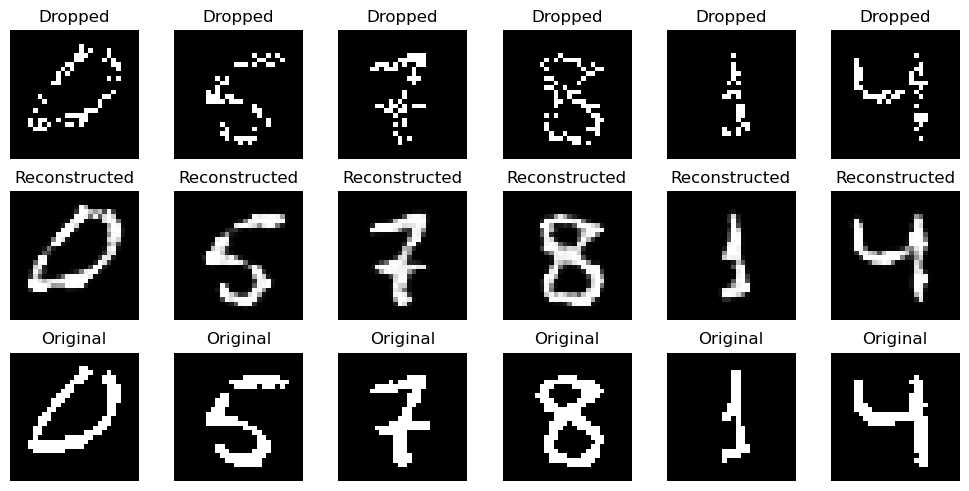

In [ ]:
show_random_predictions(model, test_loader, device, num_samples=6, drop_probability=drop_prob)
